In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
# %matplotlib inline
%config Completer.use_jedi = False

In [3]:
from datasets import InsectImgDataset
from utils import *
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

from torchvision import datasets
import torchvision.transforms as T
import torch.optim as optim
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

from category_encoders import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.utils import class_weight

setting = 'photobox'
if setting == 'photobox':
    ext = '.png'
elif setting == 'fuji':
    ext = '.jpg'
    
modelname = "densenet121"

binary = True # insect vs no-insect


# Cleaning with FastAI

In [9]:
path = Path(f'/mnt/HGST_4TB/Datasets/insect_vs_noinsect/insect_vs_noinsect_copy/')

In [11]:
from fastbook import *
from fastai.vision.all import *

In [12]:
fns = get_image_files(path)
failed = verify_images(fns)
assert not len(failed)

In [42]:
def label_func(fname):
    return "insect" if "/test/insect" in str(fname) or "/train/insect" in str(fname) else "not-insect"

In [48]:
insects = DataBlock(
    # provide a tuple where we specify what types we want for the independent and dependent variables:
    blocks=(ImageBlock, CategoryBlock), # What kinds of data we are working with
    get_items=get_image_files, # How to get the list of items
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # How to create the validation set
    get_y=label_func, # How to label these items, gets the name of the folder a file is in
    item_tfms=Resize(150)) # Transformation: picture resize

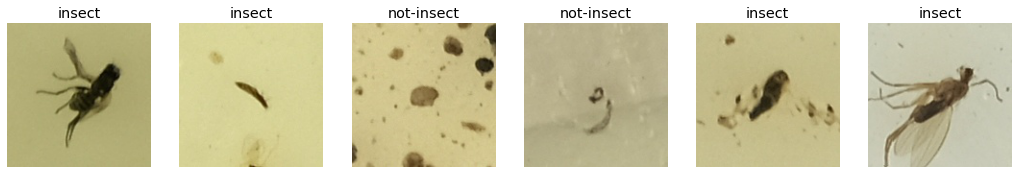

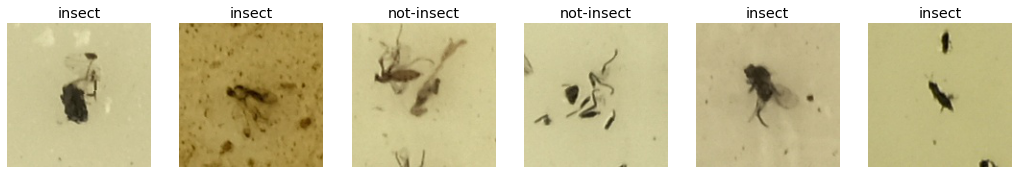

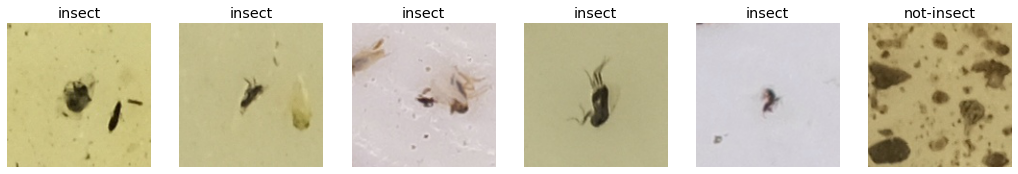

In [61]:
dls = insects.dataloaders(path) # the path where the images can be found
dls.train.show_batch(max_n=6, nrows=1) # check training set
dls.valid.show_batch(max_n=6, nrows=1) # check validation set
dls.show_batch(max_n=6, nrows=1) # check data

In [62]:
print(f"Train data: {len(dls.train.dataset)}, Valid data: {len(dls.valid.dataset)}")

Train data: 75722, Valid data: 18930


In [63]:
learn = vision_learner(dls, densenet121, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.183465,0.162593,0.064659,03:49


epoch,train_loss,valid_loss,error_rate,time
0,0.111905,0.101199,0.038880,04:59
1,0.095467,0.102505,0.039884,04:58
2,0.062284,0.093857,0.035446,05:02
3,0.020590,0.126599,0.031801,04:58
4,0.004769,0.146588,0.031907,04:57


In [64]:
import matplotlib.pyplot as plt

interp = ClassificationInterpretation.from_learner(learn)

<Figure size 1440x864 with 0 Axes>

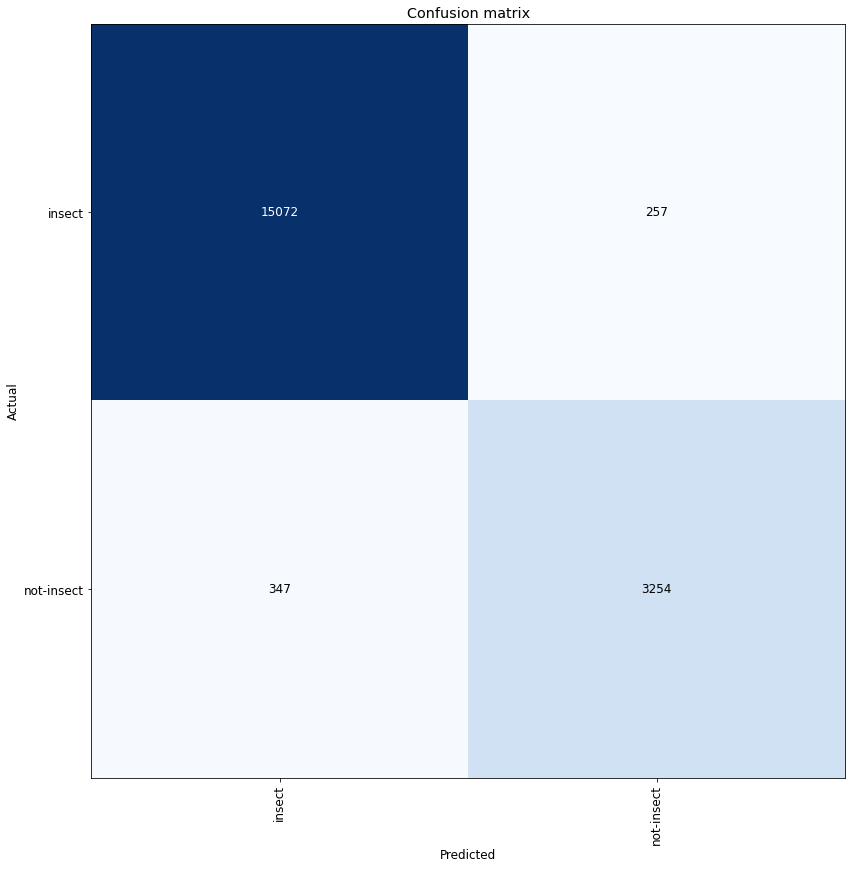

In [65]:
plt.figure(figsize=(20,12))
interp.plot_confusion_matrix(figsize=(20,12))

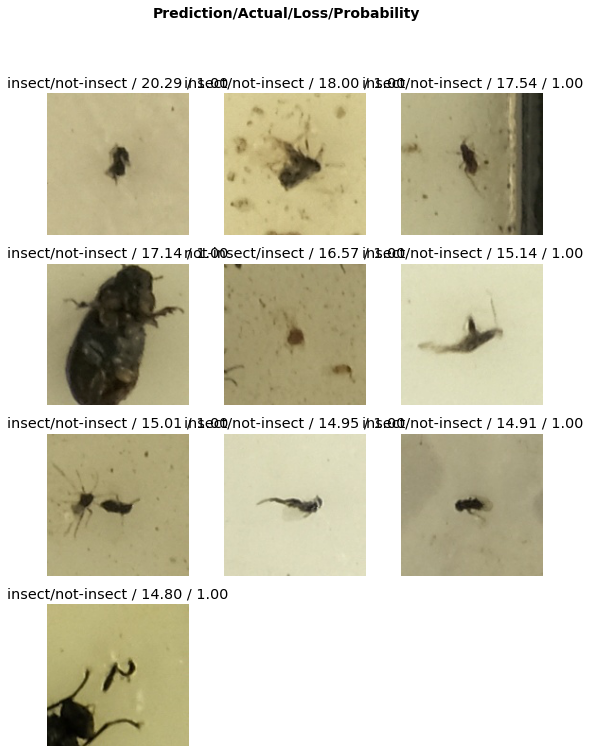

In [68]:
interp.plot_top_losses(10, nrows=4)

In [70]:
from fastai.vision.widgets import *
#hide_output
cleaner = ImageClassifierCleaner(learn)

In [71]:
def get_iw_info(
    learn,
    ds_idx:int=0 # Index in `learn.dls`
) -> list:
    "For every image in `dls` `zip` it's `Path`, target and loss"
    dl = learn.dls[ds_idx].new(shuffle=False, drop_last=False)
    probs,targs,preds,losses = learn.get_preds(dl=dl, with_input=False, with_loss=True, with_decoded=True)
    targs = [dl.vocab[t] for t in targs]
    return L([dl.dataset.items,targs,losses]).zip()

In [72]:
iwis = get_iw_info(learn,0), get_iw_info(learn,1)

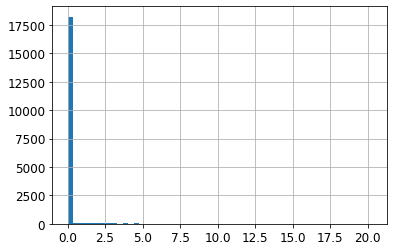

In [85]:
df = pd.DataFrame(iwis[1]).sort_values(by=2, ascending=False)
df[2].apply(lambda x: float(x)).hist(bins=55);

In [86]:
df[2].apply(lambda x: float(x)).sort_values(ascending=False).nlargest(10)

3796     20.286201
5404     18.004221
15       17.544941
4167     17.142170
16200    16.566515
7805     15.140398
11373    15.013015
15813    14.951906
6765     14.913387
18223    14.797812
Name: 2, dtype: float64

ImageClassifierCleaner doesn't actually do the deleting or changing of labels for you; it just returns the indices of items to change.


In [ ]:
cleaner

In [ ]:
# ImageClassifierCleaner doesn't actually do the deleting or changing of labels for you; it just returns the indices of items to change.

In [ ]:
# # To delete (unlink) all images selected for deletion, we would run:

# for idx in cleaner.delete(): cleaner.fns[idx].unlink()

# # To move images for which we've selected a different category, we would run:

# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)



In [ ]:
df = pd.DataFrame(iwis[0]).sort_values(by=2, ascending=False)
df[2].apply(lambda x: float(x)).hist(bins=55);

In [ ]:
df_hiloss = df[df[2]>2.5]

plt.figure(figsize=(16,12));
for i, (idx,path,target,loss) in enumerate(df_hiloss.itertuples()):
    plt.subplot(9,9,i+1);
    img = Image.open(path)
    plt.imshow(img);plt.axis('off');plt.title(f"{target}/{loss:.2f}");